Uses the best model to infer a, k, xc from collagen images.

TODO: Use a metric like r-squared or related to show goodness of fit.
TODO: Use model ensembling to find the average a, k, xc and use that as the prediction.

In [1]:
import sys
sys.path.append("../src")

In [2]:
from ds.models import SkinstressionCNN
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob
import torch
from PIL import Image
import math
from torchvision import transforms
import collections
from types import SimpleNamespace

In [3]:
def logistic(x, a, k, xc):
    return a / (1 + np.exp(-k * (x - xc)))

In [4]:
transform = transforms.Compose(
    [
        # YeoJohnsonTransform(0.466319593487972),
        transforms.ToTensor(),
        # transforms.Normalize(
        #     mean=(14.716653741103862 / 255),
        #     std=(6.557034596034911 / 255),
        # ),
        transforms.Resize((1000, 1000)),
        transforms.CenterCrop((700, 700)),
        transforms.Resize((258, 258)),
    ]
)

In [5]:
model_path = "/scistor/guest/sjg203/projects/shg-strain-stress/multirun/2023-01-11/19-27-38/0/low.pt"

In [7]:
def load_model():
    class NestedNamespace(SimpleNamespace):
        """Sot that the stub config dictionary can be accessed by the model
        as if it was the hydra config file.
        """
        def __init__(self, dictionary, **kwargs):
            super().__init__(**kwargs)
            for key, value in dictionary.items():
                if isinstance(value, dict):
                    self.__setattr__(key, NestedNamespace(value))
                else:
                    self.__setattr__(key, value)

    cfg = {
        "params": {
            "model": {
                "n_nodes": 64,
                "num_output_features": 3
            }
    }}
    cfg = NestedNamespace(cfg)

    model = SkinstressionCNN(cfg)
    checkpoint = torch.load(model_path)
    new_state_dict = collections.OrderedDict()
    for k, v in checkpoint['model_state_dict'].items():
        name = k.replace("module.", '') # remove 'module.' prefix, because of bug in checkpoint saving.
        new_state_dict[name] = v
    model.load_state_dict(new_state_dict)
    # model.load_state_dict(checkpoint["model_state_dict"])
    model = model.eval()
    model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

    return model

model = load_model()

In [8]:
file = "../data/SSCURVES.xlsx"

In [16]:
image_fns = glob("../data/sorted/**/0.bmp")

  3%|██                                                              | 2/63 [00:00<00:05, 10.98it/s]

Only curves belonging to thigh are included. Excluding person 1 (sheet 1)
Only curves belonging to thigh are included. Excluding person 1 (sheet 2)
Only curves belonging to thigh are included. Excluding person 2 (sheet 3)


  6%|████                                                            | 4/63 [00:00<00:05, 10.94it/s]/scistor/guest/sjg203/.conda/envs/stress-strain/lib/python3.9/site-packages/torchvision/transforms/functional.py:149: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


Only curves belonging to thigh are included. Excluding person 2 (sheet 4)
Only curves belonging to thigh are included. Excluding person 3 (sheet 5)


100%|███████████████████████████████████████████████████████████████| 63/63 [00:14<00:00,  4.36it/s]


No person id information found for 62
No person id information found for 555


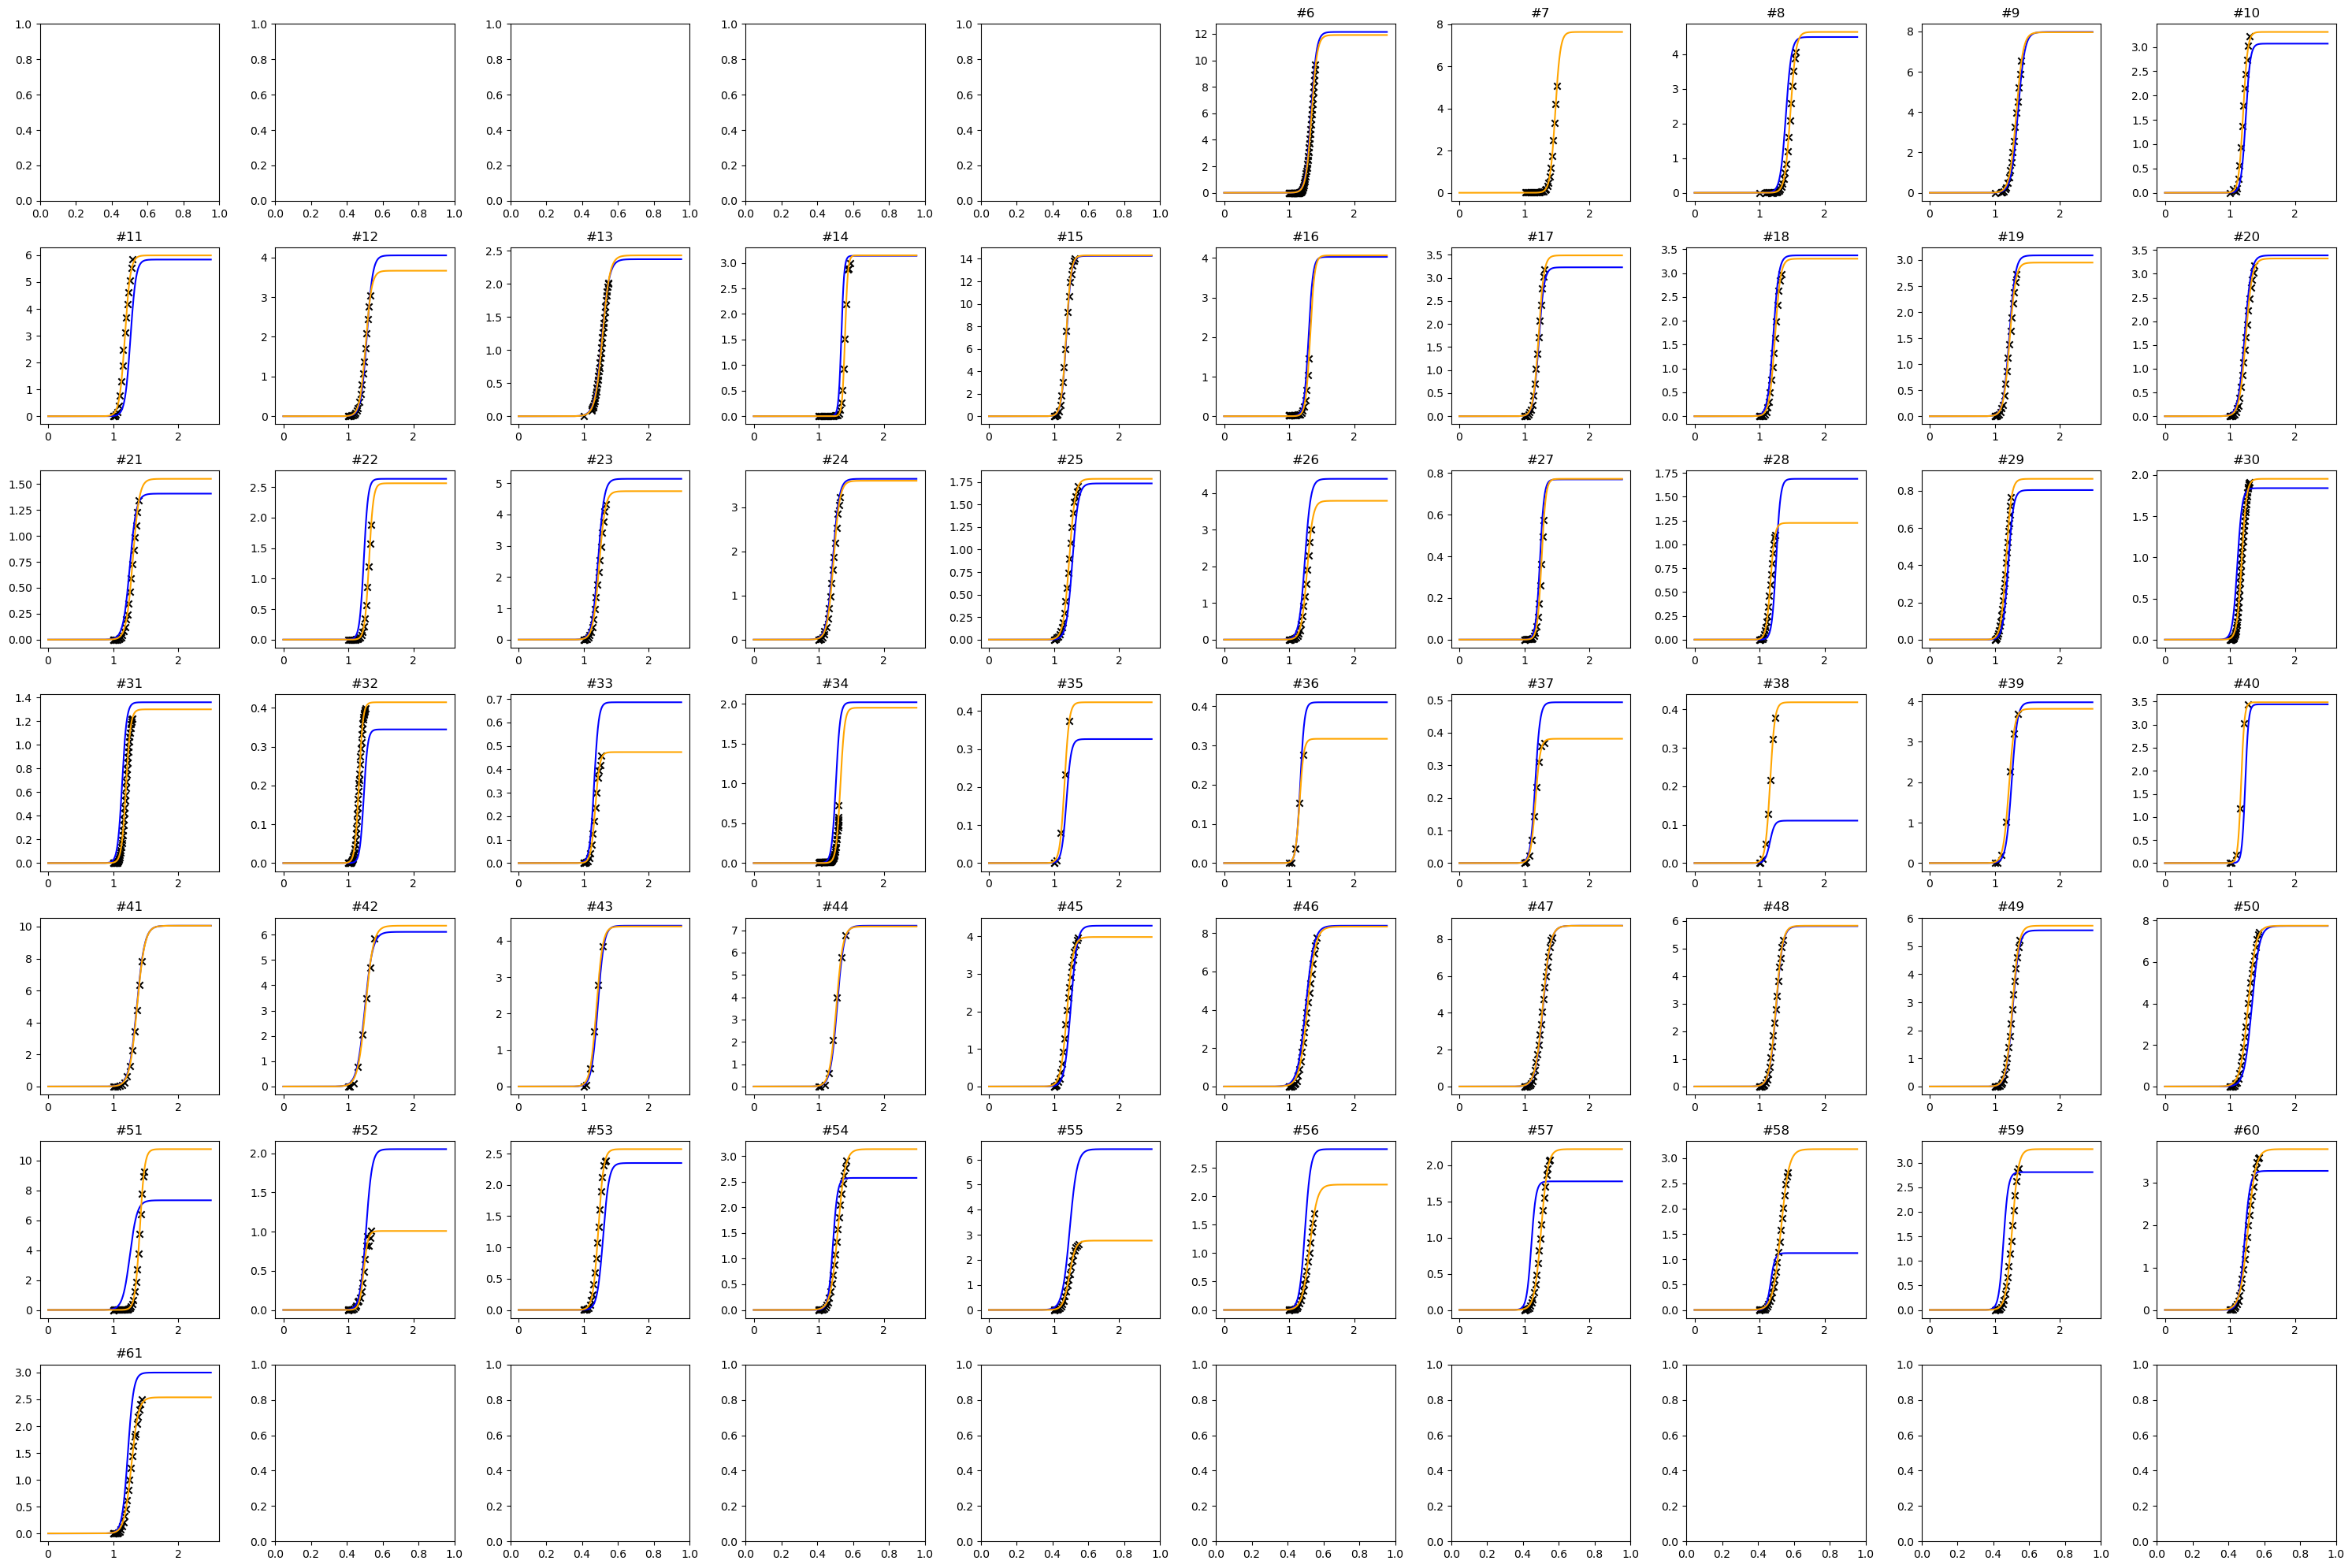

In [17]:
xls = pd.ExcelFile(file)

fig, axs = plt.subplots(7, 10, figsize=(30,20))
x = np.linspace(0, 2.5, 1000)

targets = pd.read_csv("outputs/logistic_targets.csv", index_col="index")

for sheet, ax in tqdm(zip(xls.sheet_names, axs.flat), total=len(xls.sheet_names), ncols=100):
    df = pd.read_excel(file, sheet_name=sheet)

    try:
        person_id = int(df['id'].iloc[0])
        type = str(df['type'].iloc[0])
        sex = str(df['sex'].iloc[0])
        age = str(df['age'].iloc[0])
    except KeyError:
        print(f"No person id information found for {sheet}")
        person_id = None
        continue

    valid_type = 'thigh'
    if type != valid_type:
        tqdm.write(f"Only curves belonging to {valid_type} are included. Excluding person {person_id} (sheet {sheet})")
        continue

    for fn in image_fns:
        fn_sample_id = fn.split('/')[-2]
        if fn_sample_id == sheet:
            image = np.asarray(Image.open(fn))
            image = transform(image).to('cuda' if torch.cuda.is_available else 'cpu').unsqueeze(0)
            a, k, xc = model(image).flatten().detach().cpu().numpy()
            curve = logistic(x, a, k, xc)
            ax.plot(x, curve, color='blue', label='CNN')
            break
    
    target = targets.loc[[int(sheet)]][["a", "k", "xc"]].to_numpy().flatten()
    ax.plot(x, logistic(x, *target), color='orange', label='target fit')
    
    df = df.groupby(["Strain"], as_index=False).agg({'Stress': 'mean'})
    df = df.sort_values("Strain")

    x_data = df['Strain']
    y_data = df['Stress']

    ax.scatter(x_data, y_data, marker='x', color='black', label='measurement')
    ax.set_title(f"#{sheet}")

plt.tight_layout()
plt.savefig("outputs/inference.png")
plt.show()
